In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Imports successful!")

Imports successful!


In [99]:
player_df = pd.read_csv('player_data.csv')
season_df = pd.read_csv('Seasons_Stats.csv')

In [100]:
## Clean Data 

# Strip whitespace
player_df["name"] = player_df["name"].str.strip()
season_df["Player"] = season_df["Player"].str.strip()

# Remove pre-1980 seasons
merged = season_df[season_df["Year"] >= 1980].copy()

# Merge the season stats with player data
merged = merged.merge(
    player_df,
    how="left",
    left_on="Player",
    right_on="name"
)

# Fix manually-known missing birthdays BEFORE any calculations
birthday_fixes = {
    "Bob Schafer": "March 29, 1933",
    "Don Bielke": "May 10, 1932",
    "Frank Reddout": "March 4, 1931",
    "Ken McBride": "March 23, 1929",
    "Mike O'Neill": "August 11, 1928"
}

for name, bday in birthday_fixes.items():
    merged.loc[merged["Player"] == name, "birth_date"] = bday

# Drop rows still missing birthdate (can't group them)
merged = merged.dropna(subset=["birth_date"])

# Create career-related columns
merged["career_length"] = merged["year_end"] - merged["year_start"]
merged["years_left"] = merged["year_end"] - merged["Year"]
merged["years_played"] = merged["Year"] - merged["year_start"]

# Extract birth year once (DON'T repeat this later)
merged["birth_year"] = pd.to_numeric(merged["birth_date"].str[-4:], errors="coerce")
merged["Age"] = merged["Year"] - merged["birth_year"]

# Sort cleanly
merged = merged.sort_values(["Player", "birth_date", "Year"]).reset_index(drop=True)

# Fill numeric NA
numeric_cols = merged.select_dtypes(include="number").columns
merged[numeric_cols] = merged[numeric_cols].fillna(0)

In [101]:
## Feeder School Correlation

# Handle missing colleges (treat all missing as "Unknown")
merged['college'] = merged['college'].fillna('Unknown').astype(str)

# Compute average career length per college
college_scores = (
    merged.groupby('college', as_index=False)['career_length']
          .mean()
          .rename(columns={'career_length': 'college_longevity_score'})
)

# Merge scores back into merged
merged = merged.merge(college_scores, on='college', how='left')

In [102]:
## Rookie Dataframe 

# Identify rookie year per player
rookie_year = merged.groupby(["Player", "birth_date"])["Year"].transform("min")

rookie_rows = merged[merged["Year"] == rookie_year].copy()

def choose_rookie_row(group):
    # Prefer TOT row if available
    tot = group[group["Tm"] == "TOT"]
    if len(tot) > 0:
        return tot.iloc[0]
    # else take first chronological row
    return group.iloc[0]

rookie_df = (
    rookie_rows.groupby(["Player", "birth_date"], group_keys=False)
               .apply(choose_rookie_row)
               .reset_index(drop=True)
)

# Fill any numeric NA
num_cols = rookie_df.select_dtypes(include="number").columns
rookie_df[num_cols] = rookie_df[num_cols].fillna(0)

display(rookie_df.head())
print("rookie_df shape:", rookie_df.shape)

/var/folders/8c/tydwjs_j5r3g0pdrld0bfy300000gn/T/ipykernel_33424/618413697.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(choose_rookie_row)


,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,position,height,weight,birth_date,college,career_length,years_left,years_played,birth_year,college_longevity_score
0,8035,1986.0,A.C. Green,PF,23.0,LAL,82.0,1.0,1542.0,11.8,...,F-C,6-9,220.0,"October 4, 1963",Oregon State University,15.0,15.0,0.0,1963,9.804348
1,14526,2000.0,A.J. Bramlett,C,23.0,CLE,8.0,0.0,61.0,-0.4,...,C,6-10,227.0,"January 10, 1977",University of Arizona,0.0,0.0,0.0,1977,9.239521
2,10130,1991.0,A.J. English,SG,24.0,WSB,70.0,12.0,1443.0,10.6,...,G,6-3,175.0,"July 11, 1967",Virginia Union University,1.0,1.0,0.0,1967,14.254902
3,15151,2001.0,A.J. Guyton,PG,23.0,CHI,33.0,8.0,630.0,10.3,...,G,6-1,180.0,"February 12, 1978",Indiana University,2.0,2.0,0.0,1978,6.883495
4,24304,2017.0,A.J. Hammons,C,25.0,DAL,22.0,0.0,163.0,8.4,...,C,7-0,260.0,"August 27, 1992",Purdue University,0.0,0.0,0.0,1992,7.613445


rookie_df shape: (2799, 66)


In [103]:
## Averaged Dataframe

# Define stats columns 
stat_cols = [
    'G','GS','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%',
    'TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP','FG','FGA',
    'FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB','DRB',
    'TRB','AST','STL','BLK','TOV','PF','PTS'
]

# Keep only columns that exist
stat_cols = [c for c in stat_cols if c in merged.columns]

# Average stats across all seasons for each player
avg_stats = (
    merged.groupby(["Player", "birth_date"])[stat_cols]
          .mean()
          .reset_index()
)

# Metadata to copy (first occurrence)
metadata_cols = ["college", "college_longevity_score", "career_length", "year_start", "year_end", "height", "weight"]
metadata_cols = [c for c in metadata_cols if c in merged.columns]

metadata = (
    merged.groupby(["Player", "birth_date"])[metadata_cols]
          .first()
          .reset_index()
)

# Combine everything
average_df = avg_stats.merge(metadata, on=["Player", "birth_date"], how="left")

# Fill numeric NA
num_cols = average_df.select_dtypes(include="number").columns
average_df[num_cols] = average_df[num_cols].fillna(0)

display(average_df.head())
print("average_df shape:", average_df.shape)

,Player,birth_date,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,TOV,PF,PTS,college,college_longevity_score,career_length,year_start,year_end,height,weight
0,A.C. Green,"October 4, 1963",75.611111,50.277778,2169.111111,13.872222,0.543556,0.049,0.437111,10.388889,...,83.777778,143.388889,718.222222,Oregon State University,9.804348,15.0,1986.0,2001.0,6-9,220.0
1,A.J. Bramlett,"January 10, 1977",8.000000,0.000000,61.000000,-0.400000,0.190000,0.000,0.000000,21.700000,...,3.000000,13.000000,8.000000,University of Arizona,9.239521,0.0,2000.0,2000.0,6-10,227.0
2,A.J. English,"July 11, 1967",75.500000,9.000000,1554.000000,11.550000,0.480000,0.047,0.241000,4.900000,...,101.500000,143.500000,751.000000,Virginia Union University,14.254902,1.0,1991.0,1992.0,6-3,175.0
3,A.J. Guyton,"February 12, 1978",26.666667,4.666667,415.333333,4.366667,0.324000,0.371,0.068333,1.366667,...,20.666667,19.333333,147.333333,Indiana University,6.883495,2.0,2001.0,2003.0,6-1,180.0
4,A.J. Hammons,"August 27, 1992",22.000000,0.000000,163.000000,8.400000,0.472000,0.238,0.476000,5.400000,...,10.000000,21.000000,48.000000,Purdue University,7.613445,0.0,2017.0,2017.0,7-0,260.0


average_df shape: (2799, 54)


In [104]:
## Add Rookie Age to average_df

# Extract birth_year from birth_date
average_df['birth_year'] = pd.to_numeric(
    average_df['birth_date'].str[-4:], 
    errors='coerce'
)

# Calculate rookie age
average_df['rookie_age'] = average_df['year_start'] - average_df['birth_year']

# Replace any NaN rookie_age with 0
average_df['rookie_age'] = average_df['rookie_age'].fillna(0)

# Preview
average_df[['Player', 'birth_date', 'birth_year', 'rookie_age']].head()

,Player,birth_date,birth_year,rookie_age
0,A.C. Green,"October 4, 1963",1963,23.0
1,A.J. Bramlett,"January 10, 1977",1977,23.0
2,A.J. English,"July 11, 1967",1967,24.0
3,A.J. Guyton,"February 12, 1978",1978,23.0
4,A.J. Hammons,"August 27, 1992",1992,25.0


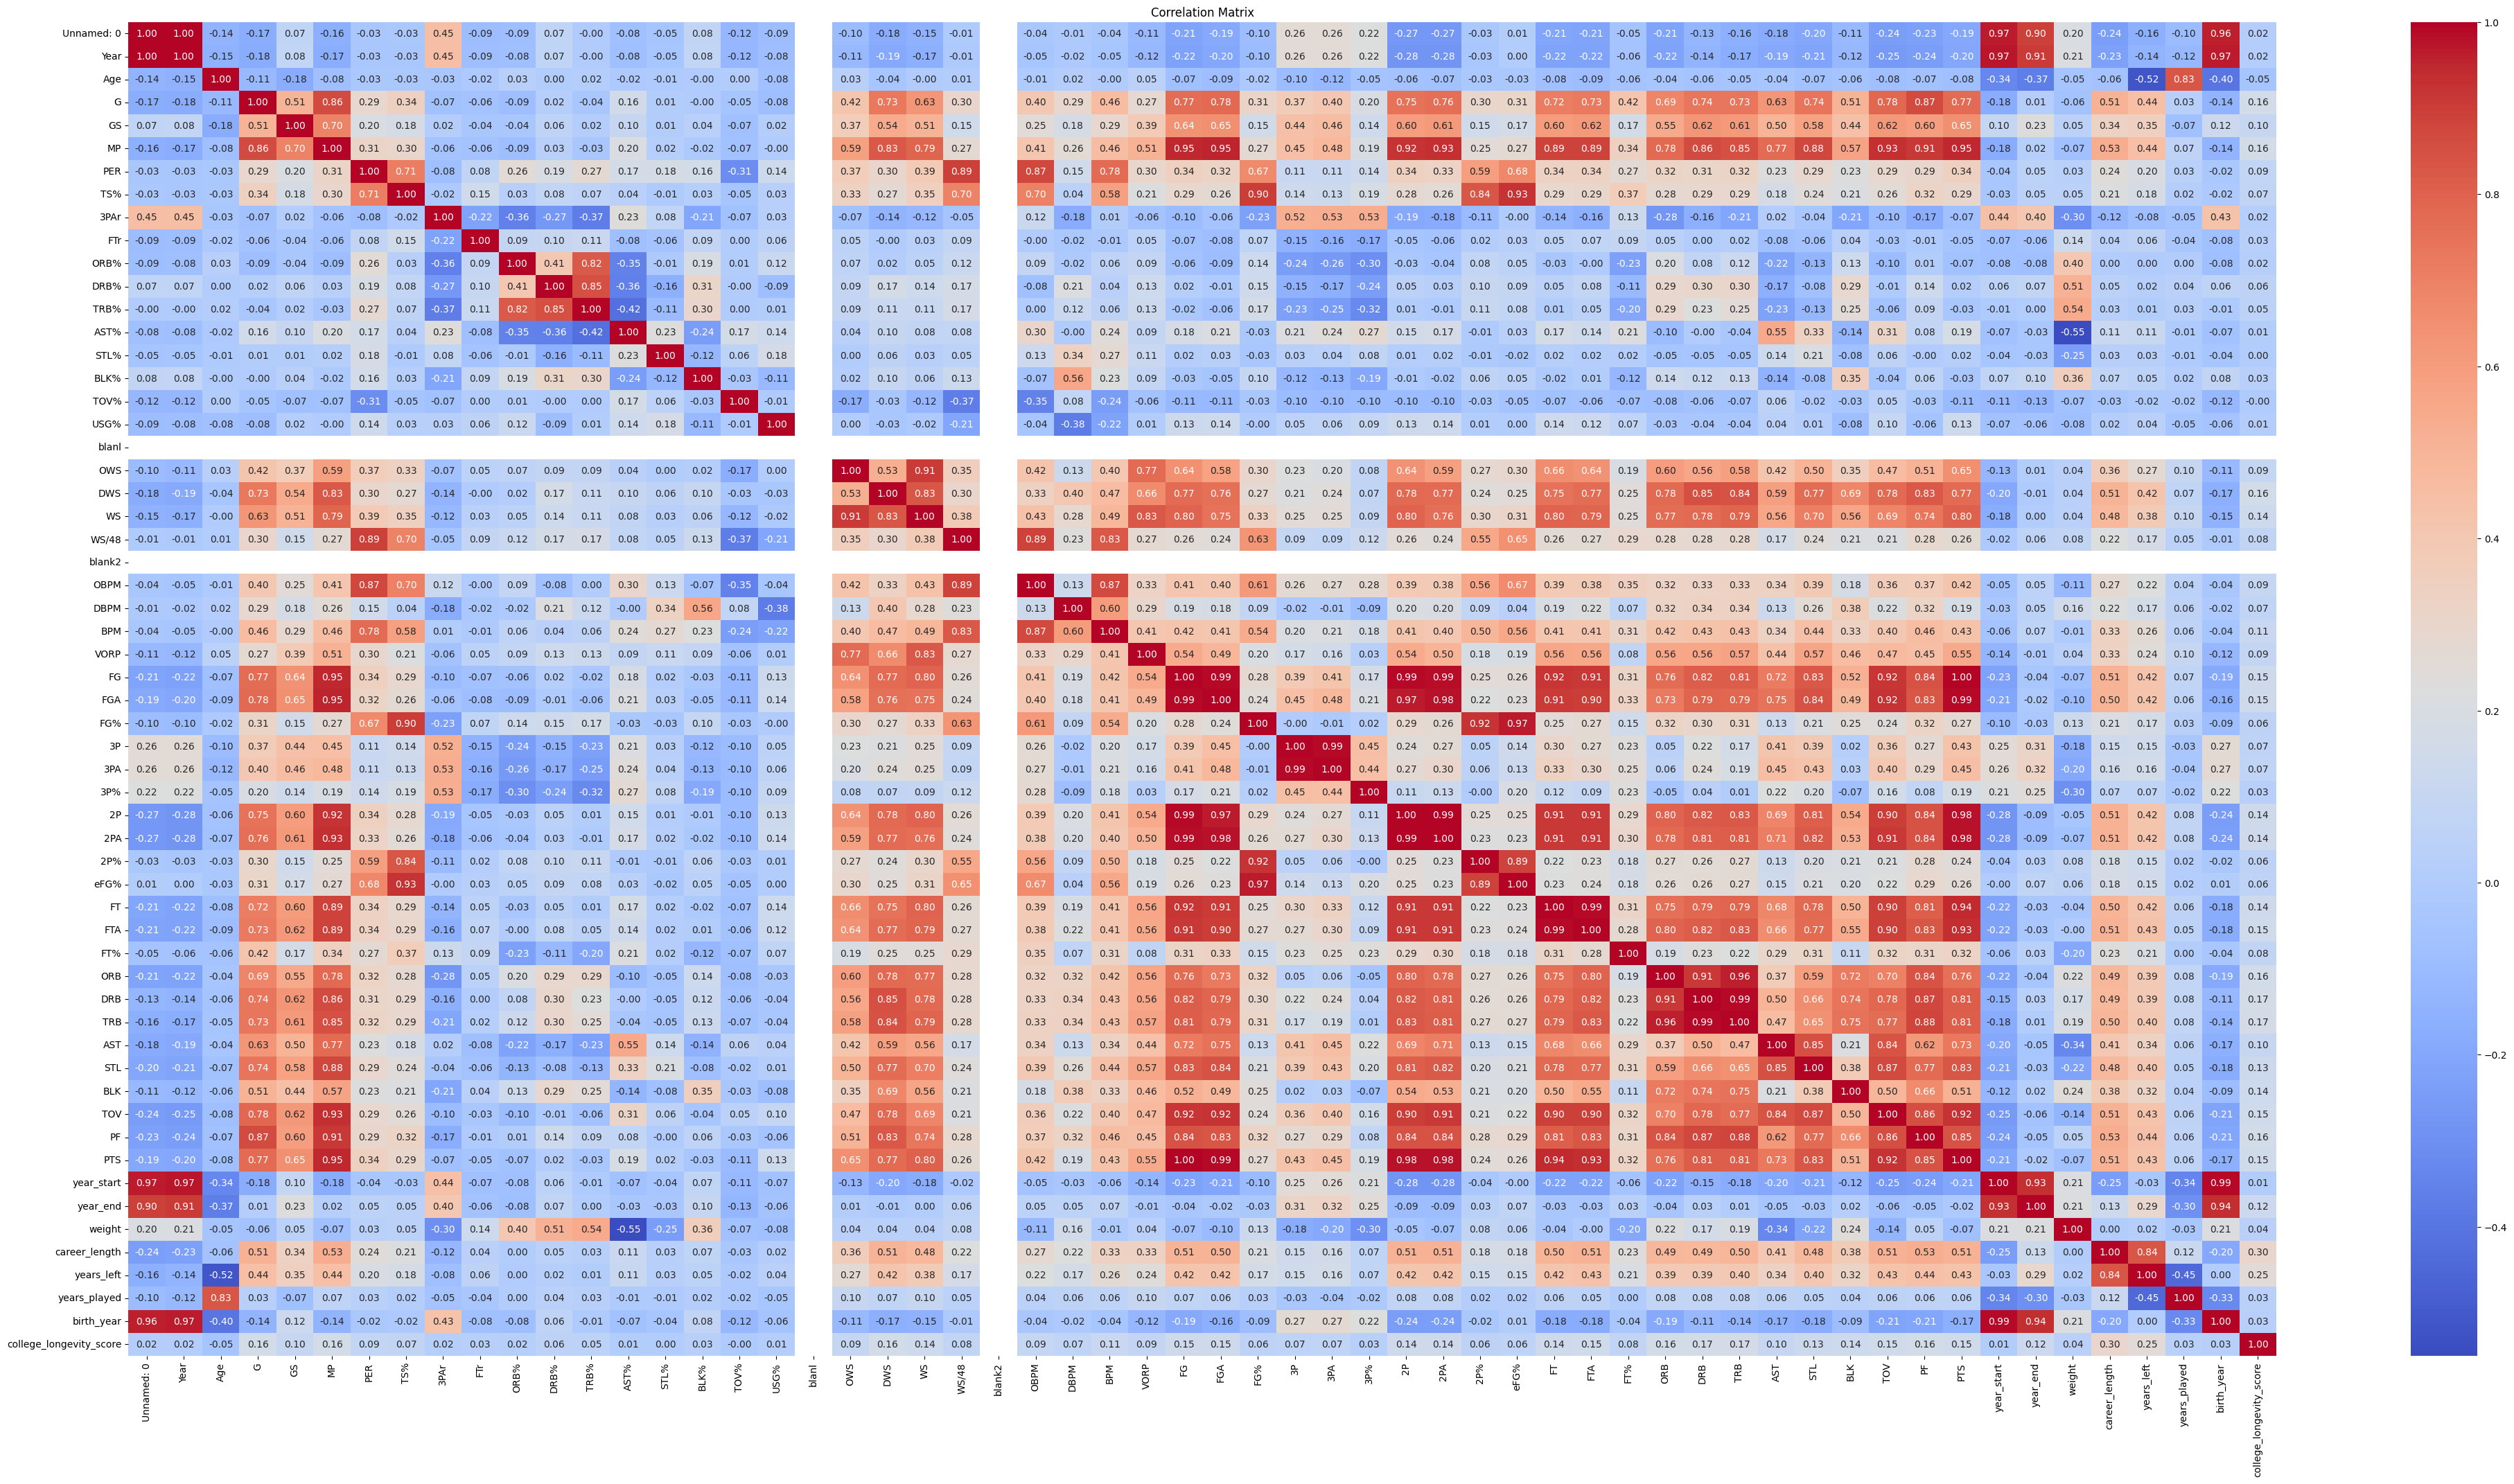

In [105]:
# Correlation Matrix FOR ROOKIE_DF 

correlation_matrix = rookie_df.corr(numeric_only=True)
# Create a masked matrix showing only correlations above 0.4 (absolute value)
# filtered_matrix = correlation_matrix[np.abs(correlation_matrix) >= 0.4]

# Optionally, replace NaNs with a visual indicator (e.g., empty string or a specific color in a heatmap)
# filtered_matrix = filtered_matrix.fillna('')

# Create a heatmap
plt.figure(figsize=(50, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

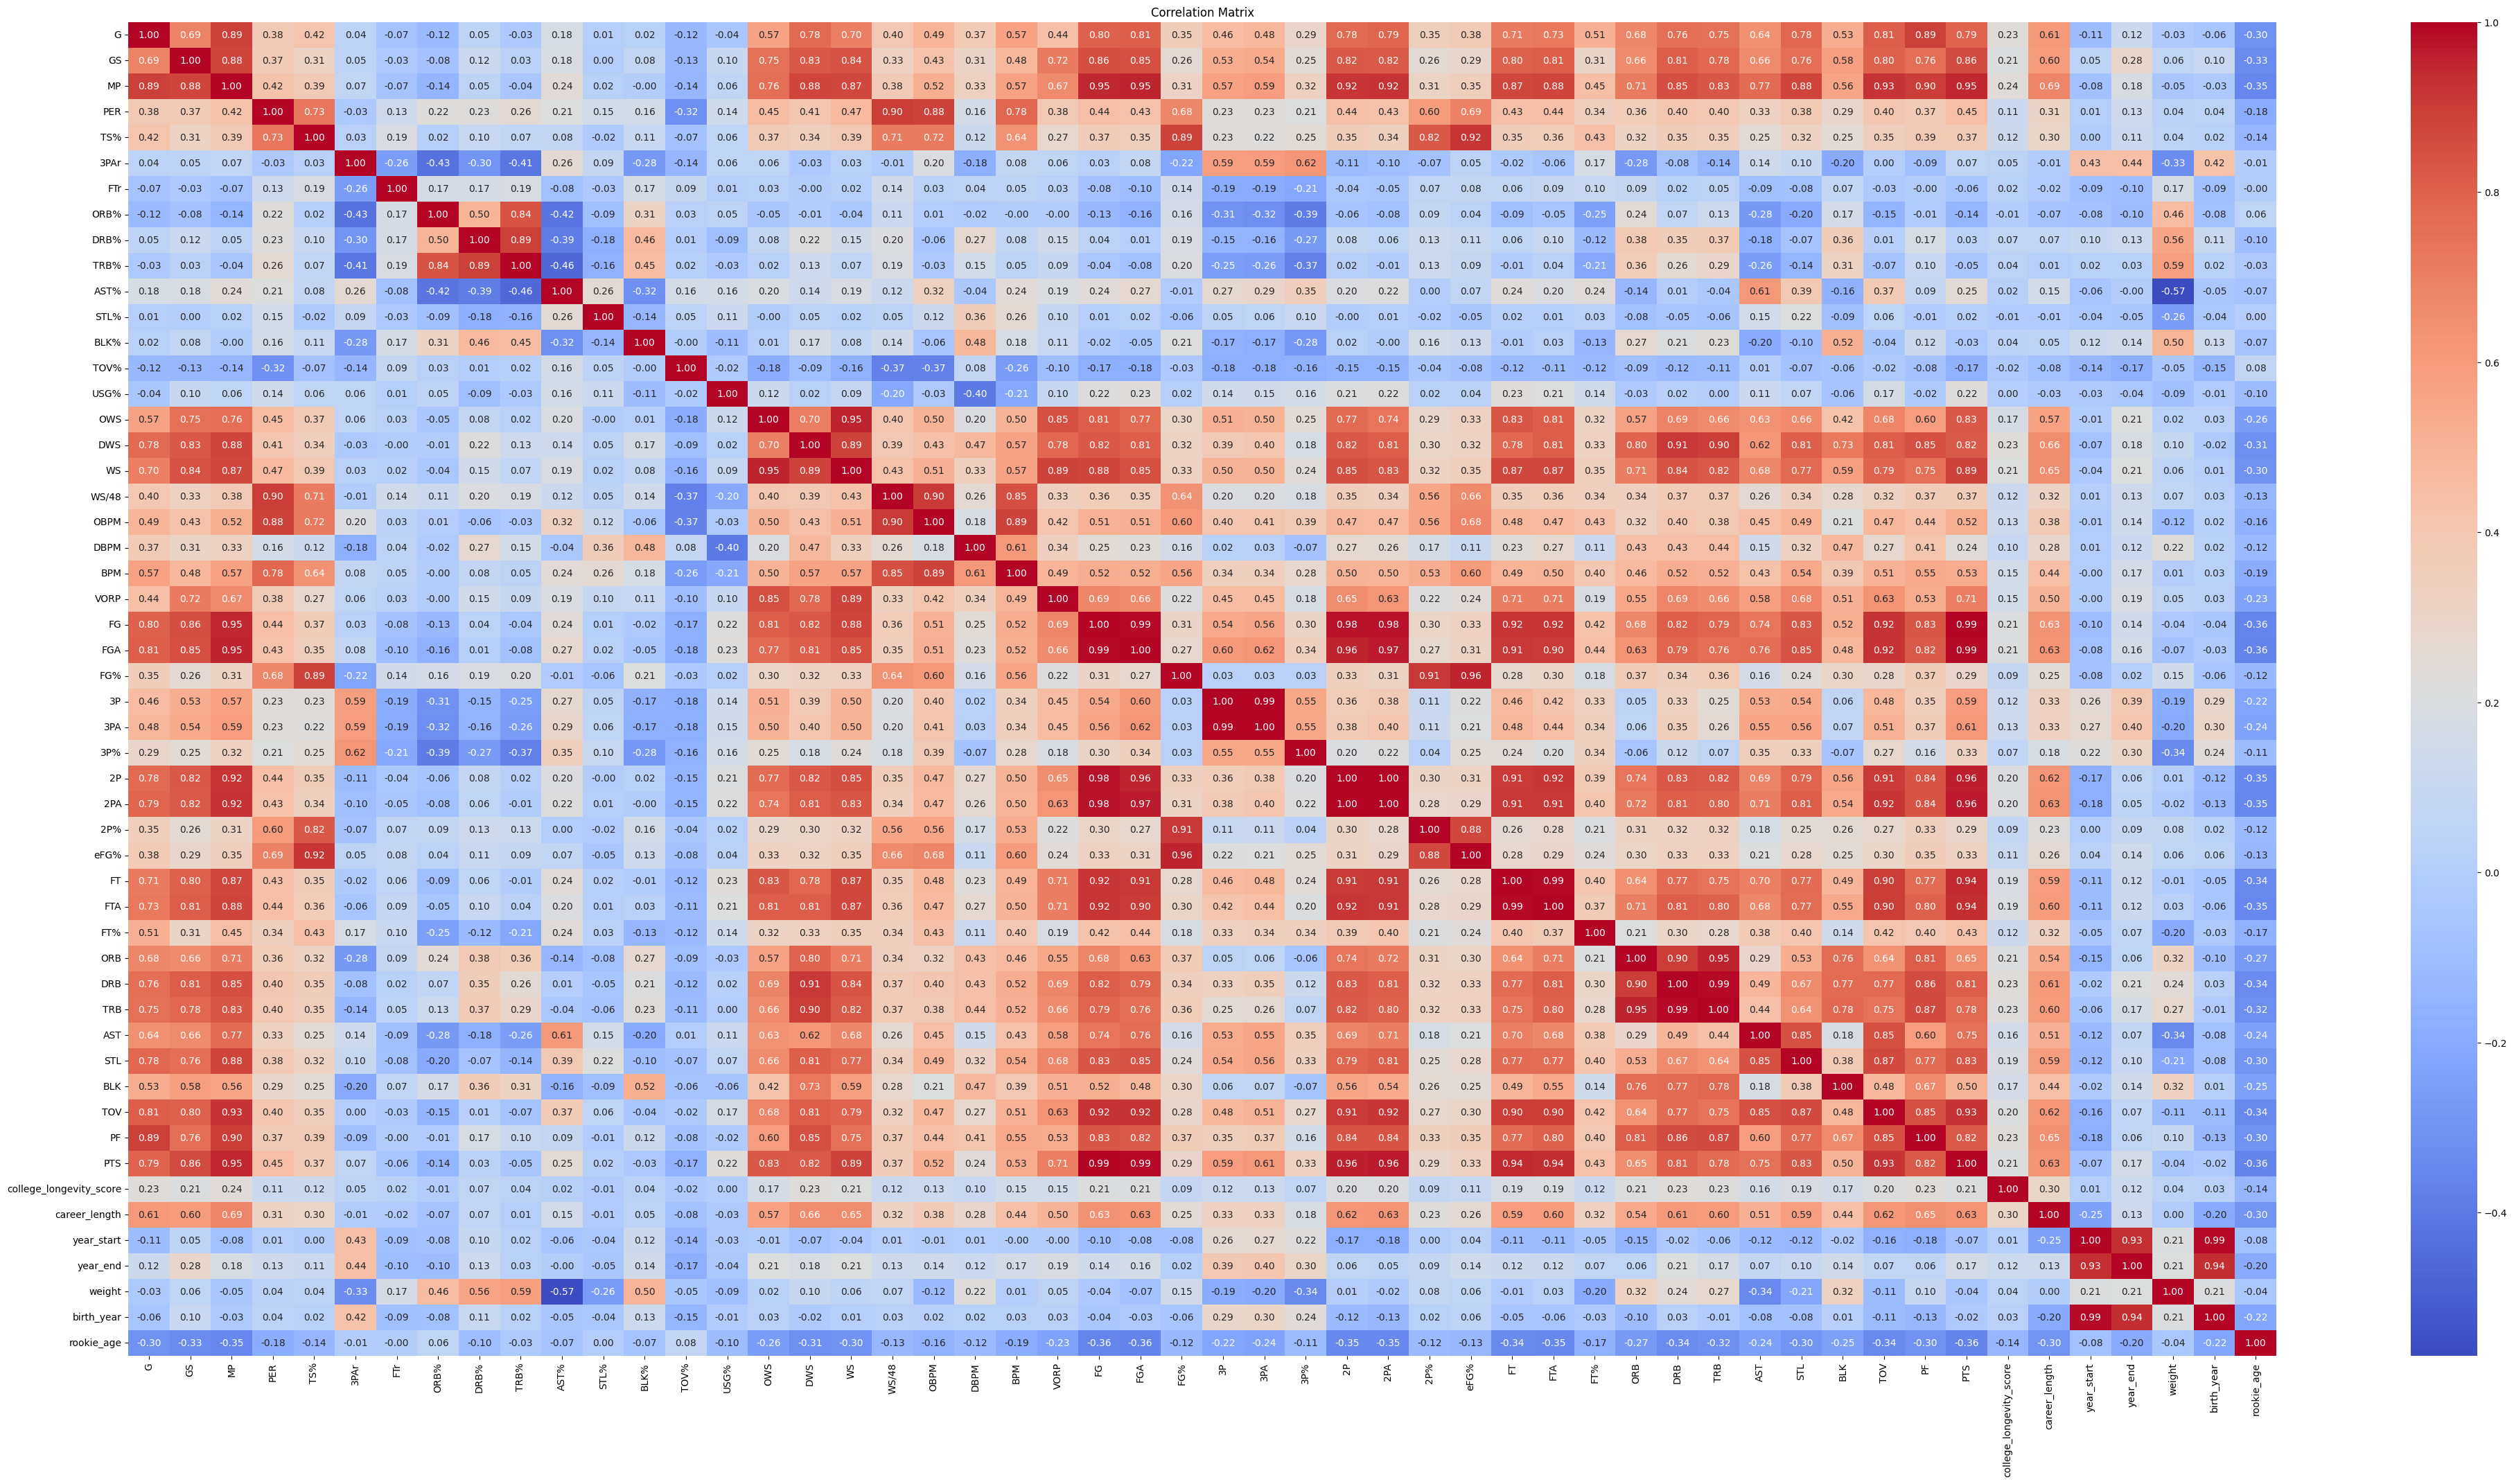

In [106]:
# Correlation Matrix FOR AVERAGE_DF 

correlation_matrix = average_df.corr(numeric_only=True)
# Create a masked matrix showing only correlations above 0.4 (absolute value)
# filtered_matrix = correlation_matrix[np.abs(correlation_matrix) >= 0.4]

# Optionally, replace NaNs with a visual indicator (e.g., empty string or a specific color in a heatmap)
# filtered_matrix = filtered_matrix.fillna('')

# Create a heatmap
plt.figure(figsize=(50, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [107]:
## FINAL FEATURED MODEL — ROOKIE DATA

feature_cols_rookie = [
    'WS',
    'college_longevity_score',
    'MP',
    'FG',
    'G',
    'DWS',
    'FGA',
    '2P',
    '2PA',
    'FT',
    'FTA',
    'ORB',
    'DRB',
    'TRB',
    'STL',
    'AST',
    'TOV',
    'PF',
    'PTS',
]

target_col = 'career_length'

model_rookie = rookie_df[feature_cols_rookie + [target_col]]

print("Shape of rookie model:", model_rookie.shape)
print(model_rookie.isna().sum())
model_rookie.head()

Shape of rookie model: (2799, 20)
WS                         0
college_longevity_score    0
MP                         0
FG                         0
G                          0
DWS                        0
FGA                        0
2P                         0
2PA                        0
FT                         0
FTA                        0
ORB                        0
DRB                        0
TRB                        0
STL                        0
AST                        0
TOV                        0
PF                         0
PTS                        0
career_length              0
dtype: int64


,WS,college_longevity_score,MP,FG,G,DWS,FGA,2P,2PA,FT,FTA,ORB,DRB,TRB,STL,AST,TOV,PF,PTS,career_length
0,3.3,9.804348,1542.0,209.0,82.0,2.0,388.0,208.0,382.0,102.0,167.0,160.0,221.0,381.0,49.0,54.0,99.0,229.0,521.0,15.0
1,-0.2,9.239521,61.0,4.0,8.0,0.1,21.0,4.0,21.0,0.0,0.0,12.0,10.0,22.0,1.0,0.0,3.0,13.0,8.0,0.0
2,0.2,14.254902,1443.0,251.0,70.0,0.7,572.0,248.0,541.0,111.0,157.0,66.0,81.0,147.0,25.0,177.0,114.0,127.0,616.0,1.0
3,0.3,6.883495,630.0,78.0,33.0,-0.1,192.0,51.0,123.0,15.0,18.0,10.0,26.0,36.0,9.0,64.0,24.0,35.0,198.0,2.0
4,0.0,7.613445,163.0,17.0,22.0,0.2,42.0,12.0,32.0,9.0,20.0,8.0,28.0,36.0,1.0,4.0,10.0,21.0,48.0,0.0


In [108]:
## FINAL FEATURED MODEL — AVERAGE DATA

feature_cols_avg = [
    'WS',
    'college_longevity_score',
    'MP',
    'FG',
    'G',
    'DWS',
    'FGA',
    '2P',
    '2PA',
    'FT',
    'FTA',
    'ORB',
    'DRB',
    'TRB',
    'STL',
    'AST',
    'TOV',
    'PF',
    'PTS',
]

model_avg = average_df[feature_cols_avg + [target_col]]

print("Shape of average model:", model_avg.shape)
print(model_avg.isna().sum())
model_avg.head()

Shape of average model: (2799, 20)
WS                         0
college_longevity_score    0
MP                         0
FG                         0
G                          0
DWS                        0
FGA                        0
2P                         0
2PA                        0
FT                         0
FTA                        0
ORB                        0
DRB                        0
TRB                        0
STL                        0
AST                        0
TOV                        0
PF                         0
PTS                        0
career_length              0
dtype: int64


,WS,college_longevity_score,MP,FG,G,DWS,FGA,2P,2PA,FT,FTA,ORB,DRB,TRB,STL,AST,TOV,PF,PTS,career_length
0,5.788889,9.804348,2169.111111,265.444444,75.611111,2.416667,538.111111,258.5,509.833333,180.388889,247.055556,198.666667,364.055556,562.722222,61.277778,81.611111,83.777778,143.388889,718.222222,15.0
1,-0.200000,9.239521,61.000000,4.000000,8.000000,0.100000,21.000000,4.0,21.000000,0.000000,0.000000,12.000000,10.000000,22.000000,1.000000,0.000000,3.000000,13.000000,8.000000,0.0
2,0.550000,14.254902,1554.000000,308.500000,75.500000,0.700000,709.000000,304.0,676.500000,129.500000,166.500000,70.000000,87.500000,157.500000,28.500000,160.000000,101.500000,143.500000,751.000000,1.0
3,0.100000,6.883495,415.333333,55.333333,26.666667,-0.033333,146.666667,31.0,82.333333,12.333333,15.000000,7.333333,19.333333,26.666667,6.666667,49.000000,20.666667,19.333333,147.333333,2.0
4,0.000000,7.613445,163.000000,17.000000,22.000000,0.200000,42.000000,12.0,32.000000,9.000000,20.000000,8.000000,28.000000,36.000000,1.000000,4.000000,10.000000,21.000000,48.000000,0.0


In [112]:
## Linear Regression - Rookie Data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. COPY DATAFRAME FOR LINEAR REGRESSION
linear_df = model_rookie.copy()

# 2. SELECT FEATURES AND TARGET
#features = ["WS", "college_longevity_score", "MP", "FG"]
features = ["WS", "college_longevity_score", "MP", "FG", "G", "DWS", "FGA", "2P", "2PA", "FT", "FTA", "ORB", "DRB", "TRB", "STL", "AST", "TOV", "PF", "PTS"]
target = "career_length"

# Drop missing values in selected columns
linear_df = linear_df[features + [target]].dropna()

X = linear_df[features]
y = linear_df[target]

# 3. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# 4. TRAIN LINEAR REGRESSION
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# 5. MAKE PREDICTIONS
y_pred = linreg.predict(X_test)

# 6. EVALUATE MODEL PERFORMANCE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nLinear Regression Performance")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")

# 7. MODEL COEFFICIENTS
coef_table = pd.DataFrame({
    "Feature": features,
    "Coefficient": linreg.coef_
})
print("\nModel Coefficients")
print(coef_table)

# 6. EVALUATE MODEL PERFORMANCE ON BOTH TRAIN AND TEST

# --- Predictions ---
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# --- Train Metrics ---
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# --- Test Metrics ---
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# --- Print Results ---
print("\nLinear Regression Performance (TRAIN)")
print(f"MSE:  {train_mse:.3f}")
print(f"RMSE: {train_rmse:.3f}")
print(f"MAE:  {train_mae:.3f}")
print(f"R²:   {train_r2:.3f}")

print("\nLinear Regression Performance (TEST)")
print(f"MSE:  {test_mse:.3f}")
print(f"RMSE: {test_rmse:.3f}")
print(f"MAE:  {test_mae:.3f}")
print(f"R²:   {test_r2:.3f}")



Train size: 2239
Test size: 560

Linear Regression Performance
MSE:  12.823
RMSE: 3.581
MAE:  2.912
R²:   0.431

Model Coefficients
                    Feature  Coefficient
0                        WS     1.812013
1   college_longevity_score     0.412173
2                        MP    -0.000253
3                        FG    -0.006396
4                         G     0.036796
5                       DWS    -0.932585
6                       FGA     0.005136
7                        2P    -0.051022
8                       2PA     0.031026
9                        FT    -0.041995
10                      FTA     0.027568
11                      ORB    -0.000072
12                      DRB    -0.002234
13                      TRB    -0.002306
14                      STL    -0.004157
15                      AST    -0.009322
16                      TOV     0.049454
17                       PF    -0.000715
18                      PTS    -0.010161

Linear Regression Performance (TRAIN)
MSE:  13.

In [113]:
## Random Forest Regression - Rookie Data

# Source: https://medium.com/data-science/random-forest-explained-a-visual-guide-with-code-examples-9f736a6e1b3c
# Source: Lab 6

# Random Forest Regression model is less likely to overfit than single decision trees
# Bootstrap sampling ensures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid to use with GridSearchCV
# Ensures ability to find ideal search space and computational cost
param_grid = {
    'n_estimators': [100, 200, 300],       # number of trees
    'max_depth': [None, 10, 20],           # max depth of trees; more trees help with overfitting
    'min_samples_split': [2, 5, 10],       # min samples to split a node; can be smaller
    'min_samples_leaf': [1, 2, 4],         # min samples required at a leaf node; can be smaller
    'max_features': ['auto', 'sqrt']       # number of features considered at each split
}

# Define tree model
# Random state = 42 ensures reproducibility
rf = RandomForestRegressor(bootstrap=True, random_state=42)

# Initialize GridSearchCV to try all combos in the grid
grid = GridSearchCV(
    estimator=rf,
    scoring='neg_mean_squared_error', # will minimize chosen metric; lower the better; negative because used to maximizing
    cv=3, # 3-fold cross-validation; train on two folds validate on 1 fold, repeat 3 times
    param_grid=param_grid,
    n_jobs=-1, # use all cores; faster training, but more memory
    verbose=2 # to log detailed results
)

# Fit the grid search
grid.fit(X_train, y_train) # these would have been initialized earlier
print(grid.best_score_)
print(grid.best_params_)

# Use best model found to run on testing data
rf = grid.best_estimator_
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate metrics
from sklearn.metrics import root_mean_squared_error, r2_score

# RMSE penalizes large mistakes more heavily, ensure sensitivity to short or long careers
# MSE is already used in model splitting
rmse = root_mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {rmse:.2f}")
print(f"Train R²: {r2:.3f}")

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")


Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split

/opt/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
243 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
215 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.13/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/site-packages/sklearn/base.py", line 471, in _validate_

-14.65227471749438
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Train RMSE: 3.66
Train R²: 0.407
Test RMSE: 3.66
Test R²: 0.407


In [115]:
## Linear Regression - Average Data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. COPY DATAFRAME FOR LINEAR REGRESSION
linear_df = model_avg.copy()

# 2. SELECT FEATURES AND TARGET
#features = ["WS", "college_longevity_score", "MP", "FG"]
features = ["WS", "college_longevity_score", "MP", "FG", "G", "DWS", "FGA", "2P", "2PA", "FT", "FTA", "ORB", "DRB", "TRB", "STL", "AST", "TOV", "PF", "PTS"]
target = "career_length"

# Drop missing values in selected columns
linear_df = linear_df[features + [target]].dropna()

X = linear_df[features]
y = linear_df[target]

# 3. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# 4. TRAIN LINEAR REGRESSION
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# 5. MAKE PREDICTIONS
y_pred = linreg.predict(X_test)

# 6. EVALUATE MODEL PERFORMANCE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nLinear Regression Performance")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")

# 7. MODEL COEFFICIENTS
coef_table = pd.DataFrame({
    "Feature": features,
    "Coefficient": linreg.coef_
})
print("\nModel Coefficients")
print(coef_table)

# 6. EVALUATE MODEL PERFORMANCE ON BOTH TRAIN AND TEST

# --- Predictions ---
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# --- Train Metrics ---
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# --- Test Metrics ---
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# --- Print Results ---
print("\nLinear Regression Performance (TRAIN)")
print(f"MSE:  {train_mse:.3f}")
print(f"RMSE: {train_rmse:.3f}")
print(f"MAE:  {train_mae:.3f}")
print(f"R²:   {train_r2:.3f}")

print("\nLinear Regression Performance (TEST)")
print(f"MSE:  {test_mse:.3f}")
print(f"RMSE: {test_rmse:.3f}")
print(f"MAE:  {test_mae:.3f}")
print(f"R²:   {test_r2:.3f}")



Train size: 2239
Test size: 560

Linear Regression Performance
MSE:  8.998
RMSE: 3.000
MAE:  2.321
R²:   0.601

Model Coefficients
                    Feature  Coefficient
0                        WS     3.842719
1   college_longevity_score     0.257642
2                        MP     0.006408
3                        FG    -0.019804
4                         G    -0.021564
5                       DWS    -1.597332
6                       FGA     0.002986
7                        2P    -0.103657
8                       2PA     0.067258
9                        FT    -0.061966
10                      FTA     0.023193
11                      ORB    -0.017423
12                      DRB     0.002408
13                      TRB    -0.015015
14                      STL    -0.038558
15                      AST    -0.026792
16                      TOV     0.084594
17                       PF     0.016406
18                      PTS    -0.017722

Linear Regression Performance (TRAIN)
MSE:  9.47

In [116]:
## Random Forest Regression - Average Data

# Source: https://medium.com/data-science/random-forest-explained-a-visual-guide-with-code-examples-9f736a6e1b3c
# Source: Lab 6

# Random Forest Regression model is less likely to overfit than single decision trees
# Bootstrap sampling ensures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid to use with GridSearchCV
# Ensures ability to find ideal search space and computational cost
param_grid = {
    'n_estimators': [100, 200, 300],       # number of trees
    'max_depth': [None, 10, 20],           # max depth of trees; more trees help with overfitting
    'min_samples_split': [2, 5, 10],       # min samples to split a node; can be smaller
    'min_samples_leaf': [1, 2, 4],         # min samples required at a leaf node; can be smaller
    'max_features': ['auto', 'sqrt']       # number of features considered at each split
}

# Define tree model
# Random state = 42 ensures reproducibility
rf = RandomForestRegressor(bootstrap=True, random_state=42)

# Initialize GridSearchCV to try all combos in the grid
grid = GridSearchCV(
    estimator=rf,
    scoring='neg_mean_squared_error', # will minimize chosen metric; lower the better; negative because used to maximizing
    cv=3, # 3-fold cross-validation; train on two folds validate on 1 fold, repeat 3 times
    param_grid=param_grid,
    n_jobs=-1, # use all cores; faster training, but more memory
    verbose=2 # to log detailed results
)

# Fit the grid search
grid.fit(X_train, y_train) # these would have been initialized earlier
print(grid.best_score_)
print(grid.best_params_)

# Use best model found to run on testing data
rf = grid.best_estimator_
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate metrics
from sklearn.metrics import root_mean_squared_error, r2_score

# RMSE penalizes large mistakes more heavily, ensure sensitivity to short or long careers
# MSE is already used in model splitting
rmse = root_mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {rmse:.2f}")
print(f"Train R²: {r2:.3f}")

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")


Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_spli

/opt/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
243 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.13/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/site-packages/sklearn/base.py", line 471, in _validate_

-8.854351738901345
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Train RMSE: 2.87
Train R²: 0.635
Test RMSE: 2.87
Test R²: 0.635
